In [2]:
import h5py
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision


In [3]:
hf = h5py.File('../data/data.h5', 'r')

attribute = np.asarray(hf['Anno_fine']['list_attr_cloth.txt'])
category = np.asarray(hf['Anno_fine']['list_category_cloth.txt'])

hf.close()

In [4]:
category_df = pd.DataFrame([x.strip().split() for x in category[1:]], dtype=str)
category_df, category_df.columns = category_df[1:] , category_df.iloc[0]

attribute_df = pd.DataFrame([x.strip().split() for x in attribute[1:]], dtype=str)
attribute_df, attribute_df.columns = attribute_df[1:] , attribute_df.iloc[0]

category_df

,category_name,category_type
1,Anorak,1
2,Blazer,1
3,Blouse,1
4,Bomber,1
5,Button-Down,1
6,Cardigan,1
7,Flannel,1
8,Halter,1
9,Henley,1
10,Hoodie,1


In [5]:
train_hf = h5py.File('../data/train_fine.h5', 'r')
test_hf  = h5py.File('../data/test_fine.h5', 'r')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
imgs = np.array(train_hf['img'])
plt.imshow(imgs[0])

(224, 224, 3)

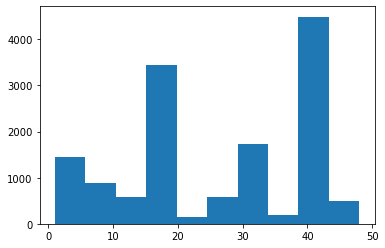

In [19]:
cats = np.asarray(train_hf['category'])
plt.hist(cats)

In [92]:
# net = dict(name='Net', exports='nn.Module' ... )

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 24, 5)
        self.conv2 = nn.Conv2d(24, 48, 5)
        
        x = torch.randn((224, 224)).view(-1, 1, 224, 224)
        x = self.convs(x)
        
        self.conv_out = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        
        self.fc1 = nn.Linear(self.conv_out, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, len(category))
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.conv_out)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.softmax(x, dim=1)

In [93]:
net = Net()

labelt = torch.tensor(np.eye(len(category)), dtype=torch.float)

In [ ]:
def test():
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_hf['img']))):
            
            img = test_hf['img'][i]
            img =  torchvision.transforms.functional.to_tensor(img)
            category = test_hf['category'][i][0]

            # print(f'{img.shape}, {category}')

            output = net(img.view(-1, 1, 224, 224))
            for idx, i in enumerate(output):
                print(f'{torch.argmax(i)} : {category}')
                if torch.argmax(i) == category:
                    correct += 1
                total += 1

    print("Accuracy: ", round(correct/total, 5))

In [ ]:
test()